In [51]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting Sensory data

- We are using data from Garmin watch. 
- For this assignment running activities were observed, specifically tempo and recovery runs. 
- 4 runs were extracted: 12km tempo, 10km tempo, 10km recovery, 8km recovery. In total, ~4h of data. Each run activity is labeled according to its type and distance.
- **Features:** 
    - Time
    - Distance
    - Altitude
    - Cadence
    - HeartRate
    - Speed
- **Engineered features (TBD):**
    - Pace (Time/Distance)
    - Elevation Gain (to be calculated)
    - Cadence per minute (In current dataset cadence metric is really akward and hardly understandable. Usually, cadence measures frequency of steps (for both feet) per minute. Moreover, in this dataset cadence corresponds to frequency of steps only for one foot, so it should be multiplied by 2)

In [52]:
def parse_tcx(tcx_file):
    tree = ET.parse(tcx_file)
    root = tree.getroot()

    data = []
    
    for activity in root.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities'):
        for lap in activity.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Lap'):
            for track in lap.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Track'):
                for trackpoint in track.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Trackpoint'):
                    # Extract time, distance, and heart rate data
                    time_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time')
                    distance_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters')
                    heart_rate_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}HeartRateBpm/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Value')
                    speed_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Extensions/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Speed')
                    run_cadence_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Extensions/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}RunCadence')
                    altitude_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}AltitudeMeters')
                    
                    if time_element is not None and distance_element is not None and heart_rate_element is not None and run_cadence_element is not None and speed_element is not None:
                        data.append({
                            'Time': time_element.text,
                            'Distance': float(distance_element.text),
                            'Altitude': float(altitude_element.text),
                            'HeartRate': int(heart_rate_element.text),
                            'Speed': float(speed_element.text),
                            'Cadence': int(run_cadence_element.text)
                        })

    return data

def heart_rate_zone(heart_rate):
    # Define your own heart rate zones here
    if heart_rate <= 141:
        return 'Zone 1'
    elif heart_rate >= 142 and heart_rate <= 157:
        return 'Zone 2'
    elif heart_rate >= 158 and heart_rate <= 167:
        return 'Zone 3'
    elif heart_rate >= 168 and heart_rate <= 174:
        return 'Zone 4'
    elif heart_rate > 174:
        return 'Zone 5'


# Calculate pace (time per km) - note this is a simple calculation and may not be accurate
def calculate_pace(df):
    df['Time'] = pd.to_datetime(df['Time'])
    timeDiff = df['Time'].diff()
    distanceDiff = df['Distance'].diff()
    df['Pace'] = timeDiff.dt.total_seconds() / distanceDiff
    

#Activity labels. Currently not used
labels = ['recovery','tempo']

In [53]:
tcx_files = ['10km_tempo.tcx', '12km_tempo.tcx', '8km_recovery.tcx', '10km_recovery.tcx']

dataframes = []

for file in tcx_files:
    # Parse the TCX file to a DataFrame
    data = parse_tcx('data/'+ file)
    df = pd.DataFrame(data)
    calculate_pace(df)
    df['HeartRateZone'] = df['HeartRate'].apply(heart_rate_zone)
    df['Run'] = os.path.splitext(file)[0]  # extracts "10km_tempo", "12km_tempo", etc. from file names

    # Append the DataFrame to the list
    dataframes.append(df)
# Concatenate all dataframes
all_runs_df = pd.concat(dataframes, ignore_index=True)
all_runs_df.to_csv('running_data.csv')

## Initial exploratory Data Analysis

In [54]:
data = pd.read_csv('running_data.csv', delimiter = ',')

print(data)

       Unnamed: 0                       Time      Distance    Altitude  \
0               0  2022-07-29 05:21:40+00:00      1.200000  325.600006   
1               1  2022-07-29 05:21:41+00:00      3.670000  325.600006   
2               2  2022-07-29 05:21:42+00:00      6.070000  325.600006   
3               3  2022-07-29 05:21:43+00:00      7.870000  325.600006   
4               4  2022-07-29 05:21:44+00:00     10.080000  325.600006   
...           ...                        ...           ...         ...   
15113       15113  2022-09-06 06:00:59+00:00  10003.740234   -1.000000   
15114       15114  2022-09-06 06:00:59+00:00  10003.740234   -1.000000   
15115       15115  2022-09-06 06:01:00+00:00  10006.309570   -0.800000   
15116       15116  2022-09-06 06:01:01+00:00  10010.650391   -0.800000   
15117       15117  2022-09-06 06:01:02+00:00  10010.650391   -0.800000   

       HeartRate  Speed  Cadence      Pace HeartRateZone            Run  
0             92  0.000       83     

In [55]:
# subsets per different run 

grouped_df = data.groupby('Run')

# Create a dictionary of DataFrames, where each DataFrame corresponds to a unique value in 'Category'
dataframes = {group: frame for group, frame in grouped_df}

# Access individual DataFrames
df_A = dataframes['10km_tempo']
df_B = dataframes['10km_recovery']
# df_C = dataframes['C']

# print(df_A)

unique_values = data['Run'].unique()
unique_values


array(['10km_tempo', '12km_tempo', '8km_recovery', '10km_recovery'],
      dtype=object)

In [56]:
#fixing Cadence to be for both feet
data['Cadence'] = data['Cadence'] * 2

In [57]:
subset = data[12500:12600]  


def count_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing values per column:")
    for column, count in missing_values.iteritems():
        print(f"{column}: {count}")

# Example usage:
df = pd.DataFrame({
    'A': [1, 2, None, 4],
    'B': [5, None, 7, 8],
    'C': [9, 10, 11, None]
})

count_missing_values(data)

Missing values per column:
Unnamed: 0: 0
Time: 0
Distance: 0
Altitude: 0
HeartRate: 0
Speed: 0
Cadence: 0
Pace: 44
HeartRateZone: 0
Run: 0


/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_19373/1958375496.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, count in missing_values.iteritems():


### Analysis for whole dataset

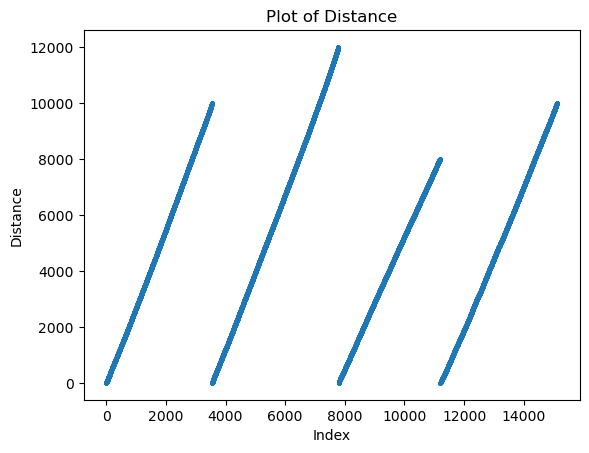

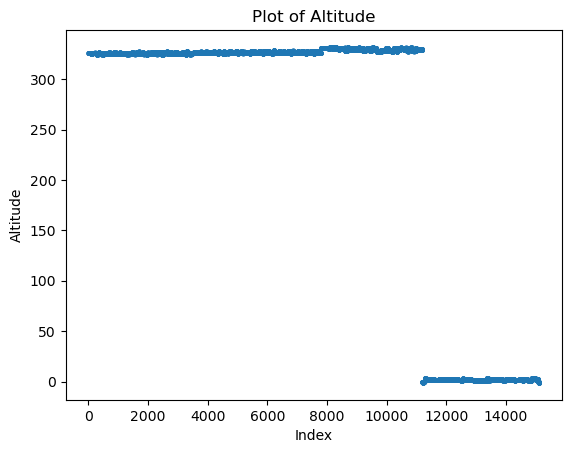

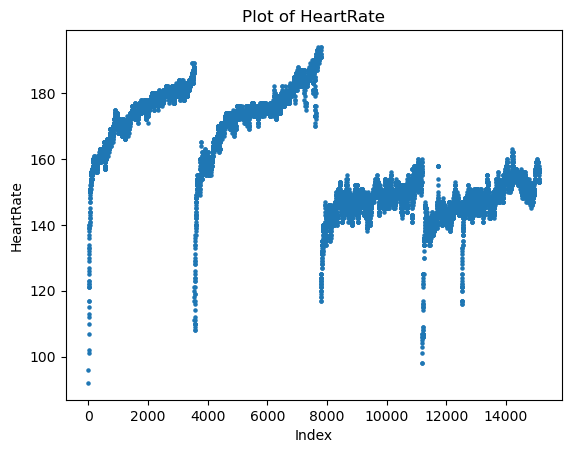

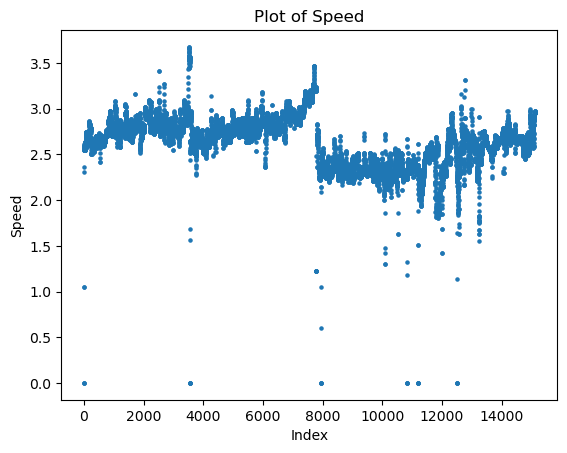

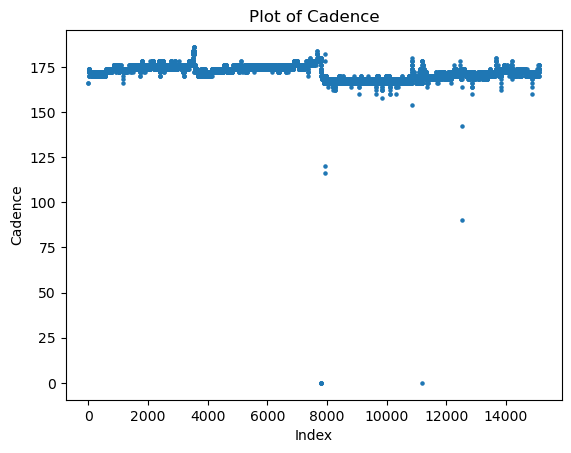

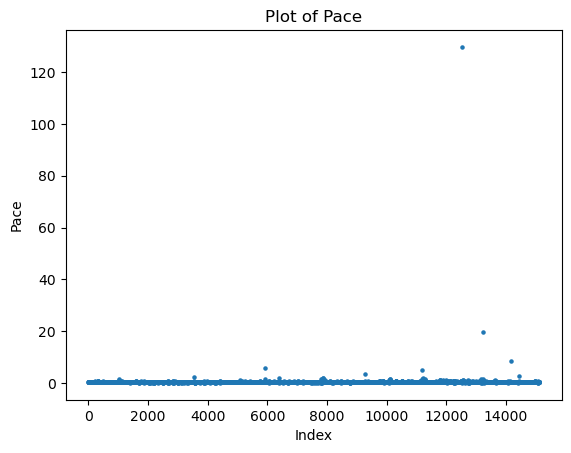

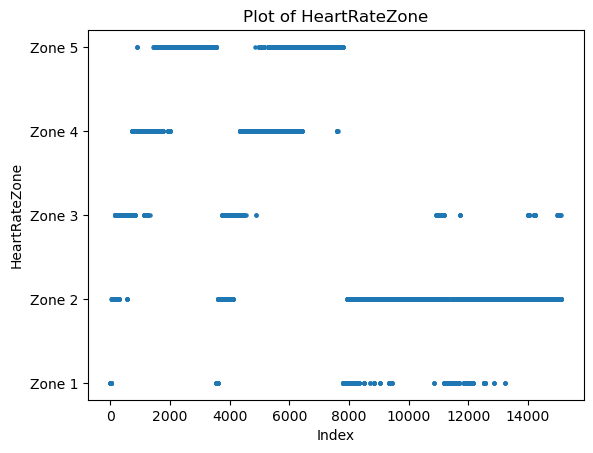

In [58]:
def plot_column(df, column_name):
    # plt.plot(df[column_name])
    plt.scatter(df.index, df[column_name], marker='o', s=5)
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f'Plot of {column_name}')
    plt.show()


plot_column(data, 'Distance')
plot_column(data, 'Altitude')
plot_column(data, 'HeartRate')
plot_column(data, 'Speed')
plot_column(data, 'Cadence')
plot_column(data, 'Pace')
plot_column(data, 'HeartRateZone')


### Distribution of features per each run

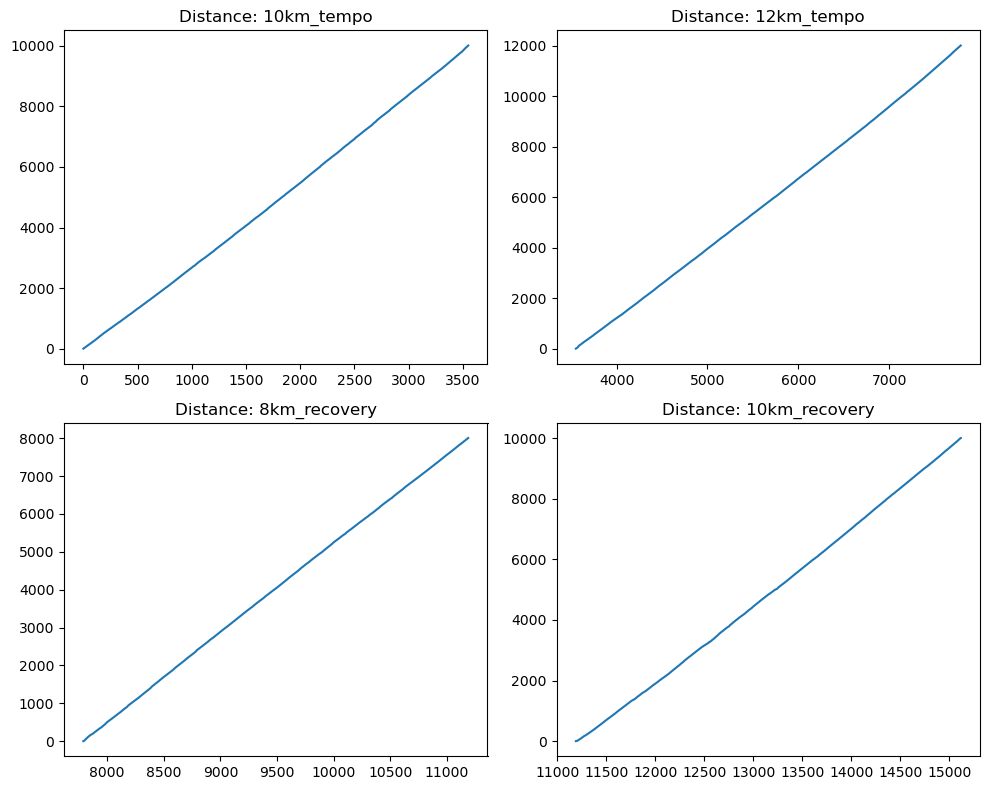

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# Iterate over each run type and plot the feature in the corresponding subplot
for i, run_type in enumerate(data['Run'].unique()):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot
    subset = data[data['Run'] == run_type]  # Filter the data for the specific run type
    
    # Plot the feature for the run type
    ax.plot(subset['Distance'])
    ax.set_title(f'Distance: {run_type}')  # Set the subplot title
    

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

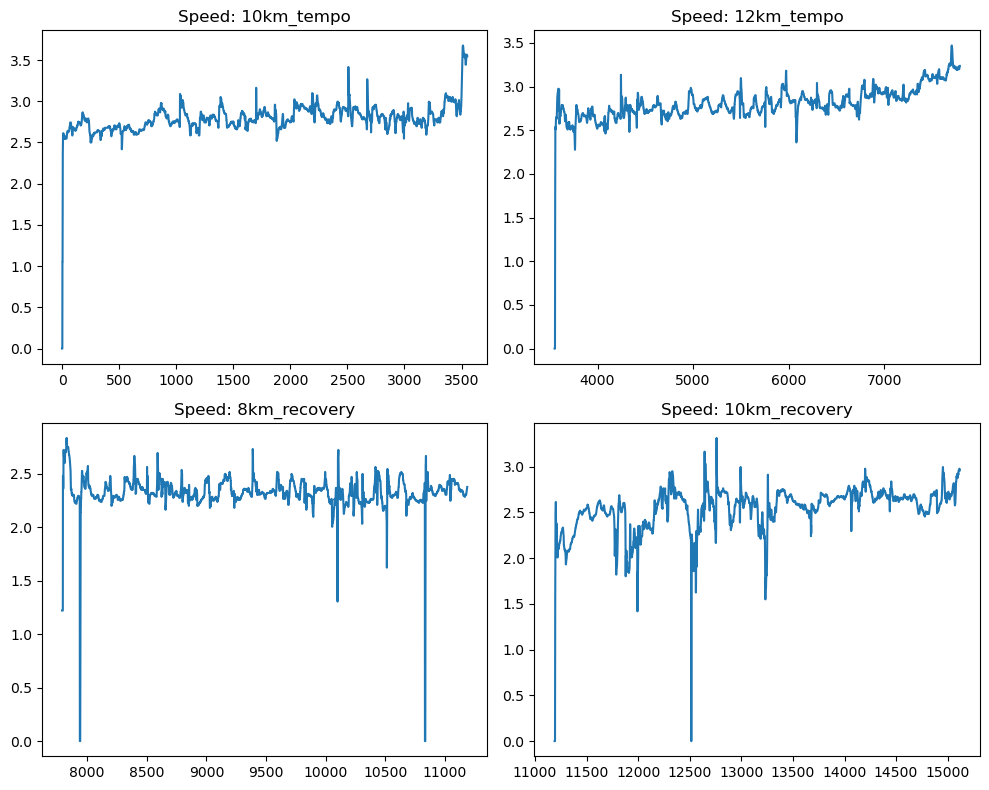

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# Iterate over each run type and plot the feature in the corresponding subplot
for i, run_type in enumerate(data['Run'].unique()):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot
    subset = data[data['Run'] == run_type]  # Filter the data for the specific run type
    
    # Plot the feature for the run type
    ax.plot(subset['Speed'])
    ax.set_title(f'Speed: {run_type}')  # Set the subplot title
    

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

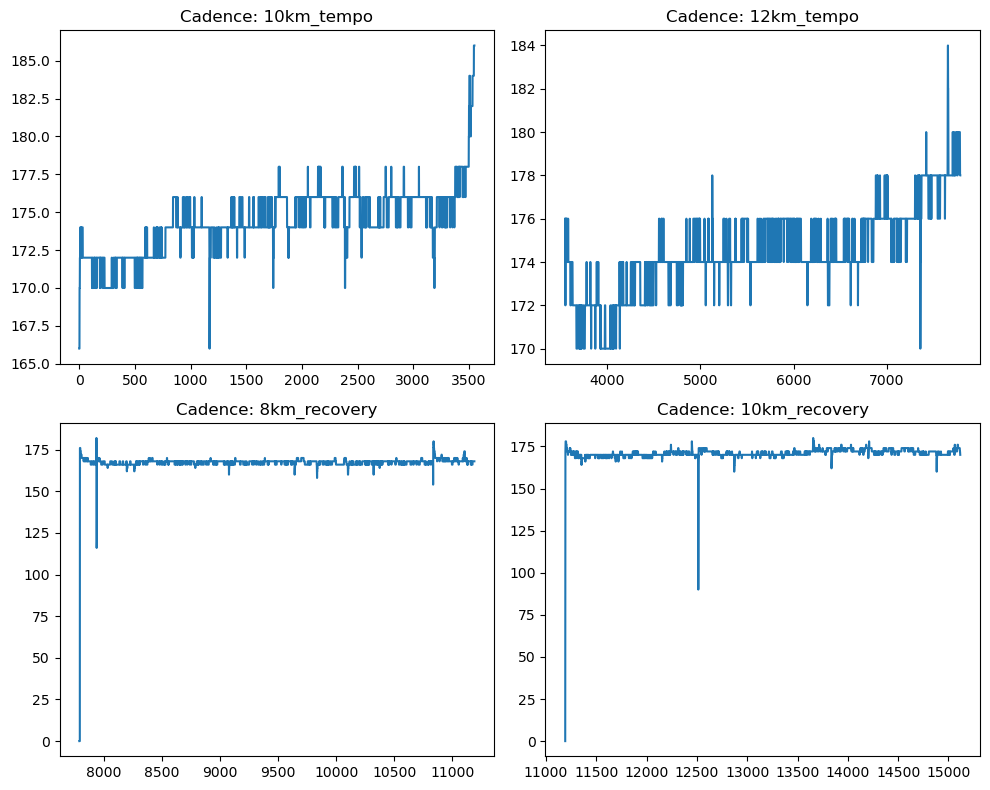

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# Iterate over each run type and plot the feature in the corresponding subplot
for i, run_type in enumerate(data['Run'].unique()):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot
    subset = data[data['Run'] == run_type]  # Filter the data for the specific run type
    
    # Plot the feature for the run type
    ax.plot(subset['Cadence'])
    ax.set_title(f'Cadence: {run_type}')  # Set the subplot title
    

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

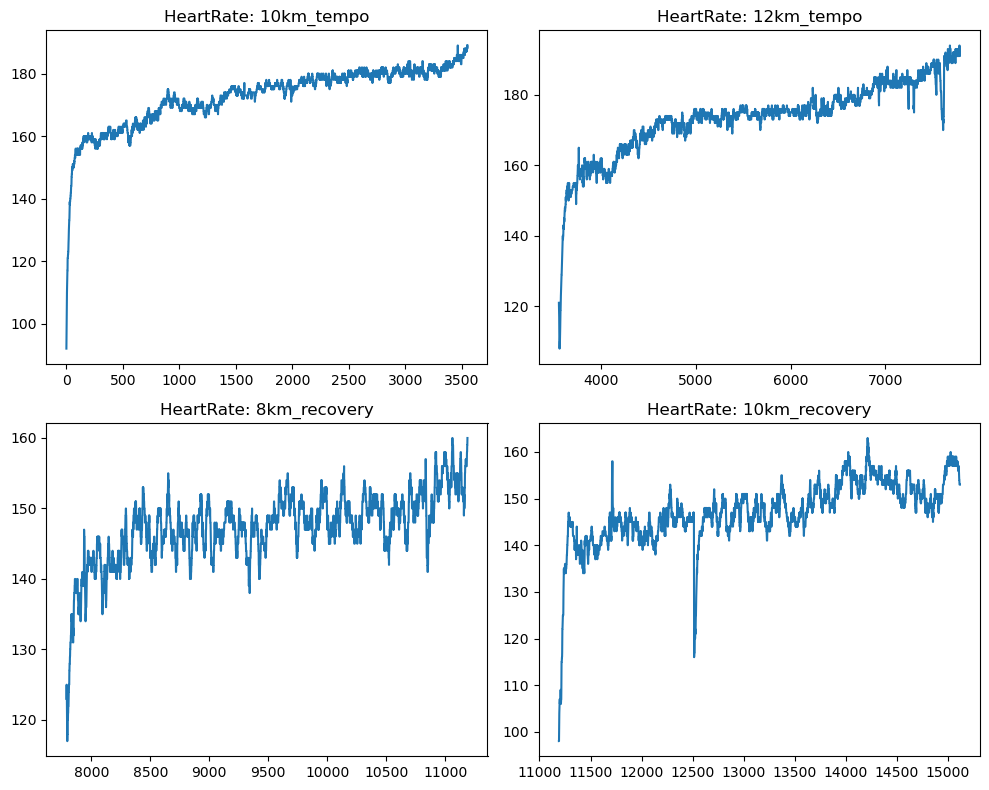

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# Iterate over each run type and plot the feature in the corresponding subplot
for i, run_type in enumerate(data['Run'].unique()):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot
    subset = data[data['Run'] == run_type]  # Filter the data for the specific run type
    
    # Plot the feature for the run type
    ax.plot(subset['HeartRate'])
    ax.set_title(f'HeartRate: {run_type}')  # Set the subplot title
    

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

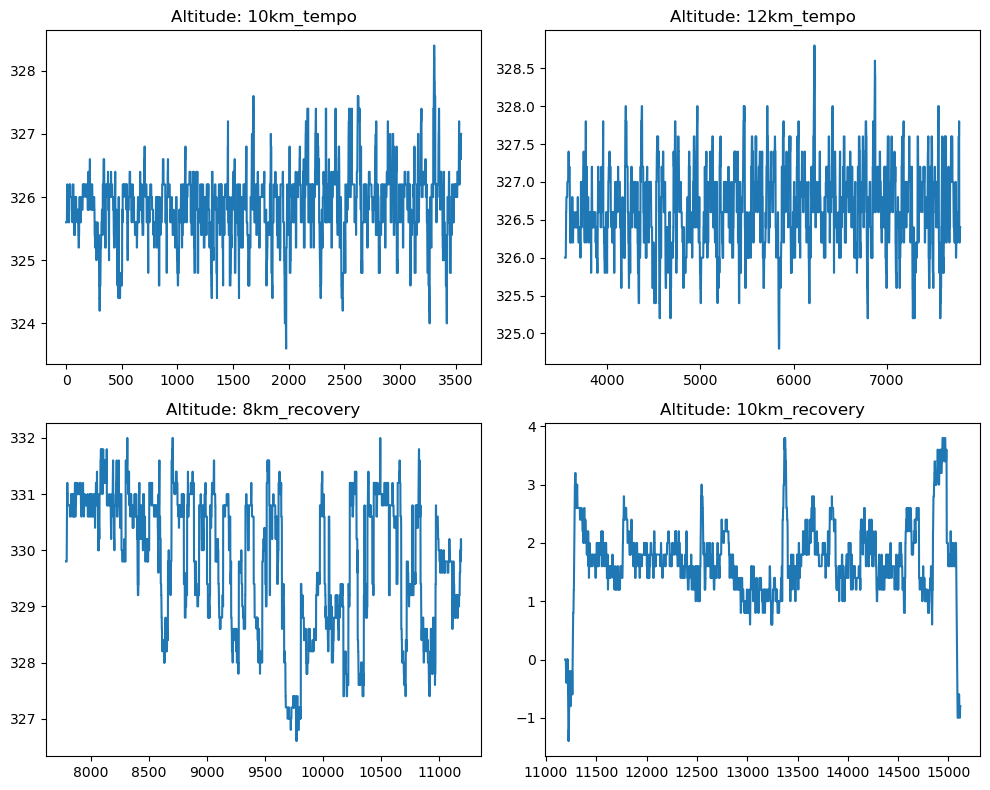

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# Iterate over each run type and plot the feature in the corresponding subplot
for i, run_type in enumerate(data['Run'].unique()):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot
    subset = data[data['Run'] == run_type]  # Filter the data for the specific run type
    
    # Plot the feature for the run type
    ax.plot(subset['Altitude'])
    ax.set_title(f'Altitude: {run_type}')  # Set the subplot title
    

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

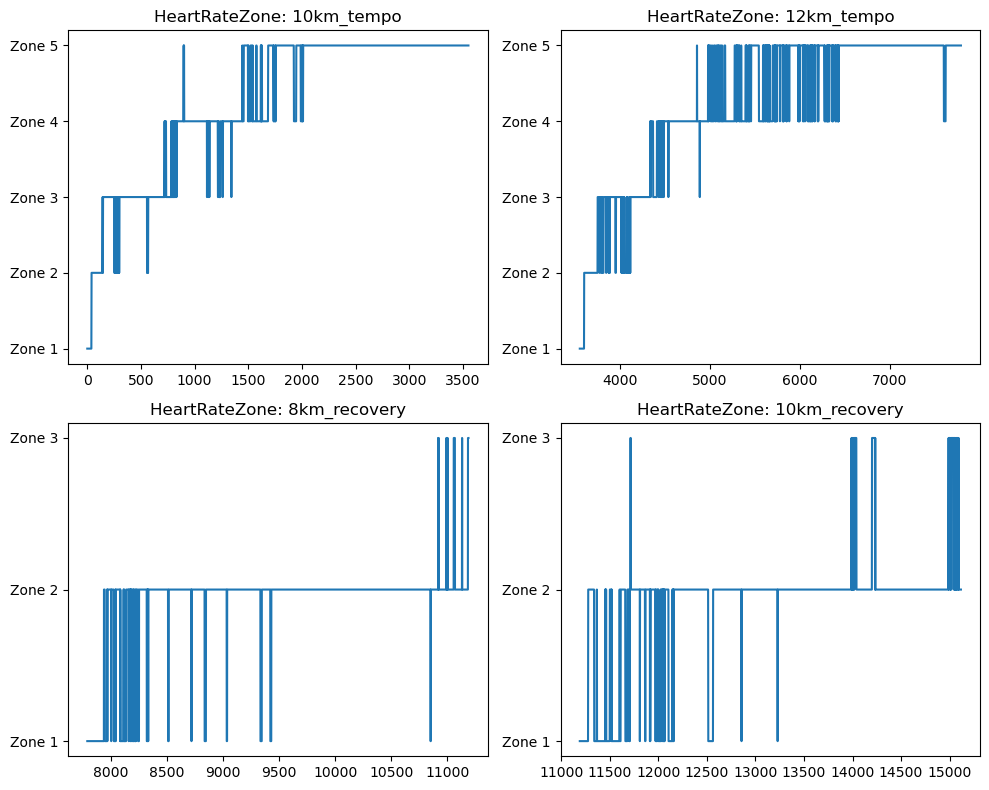

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# Iterate over each run type and plot the feature in the corresponding subplot
for i, run_type in enumerate(data['Run'].unique()):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot
    subset = data[data['Run'] == run_type]  # Filter the data for the specific run type
    
    # Plot the feature for the run type
    ax.plot(subset['HeartRateZone'])
    ax.set_title(f'HeartRateZone: {run_type}')  # Set the subplot title
    

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

### Removing outliers

### Heart rate

In [79]:
data['HeartRate'] = data['HeartRate'].astype(float)

last_value = data['HeartRate'].iloc[0]
last_run = data['Run'].iloc[0]
for index, row in data.iterrows():
    current_value = row['HeartRate']
    current_run = row['Run']
    if(last_run == current_run) and ((current_value - last_value) > 7 or (last_value - current_value) > 7):
        # Remove the current value
        # df_D_clean.drop(index, inplace=True)
        data.at[index, 'HeartRate'] = np.nan
        #print('drop')
    else:
        last_value = current_value
        last_run = current_run


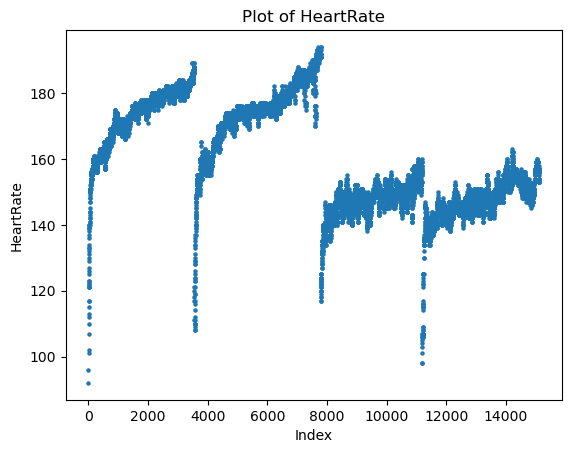

In [80]:
plot_column(data, 'HeartRate')

### Cadence

### Speed

## Imputing missing values

## Exploratory data analysis

/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_19373/1810984961.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


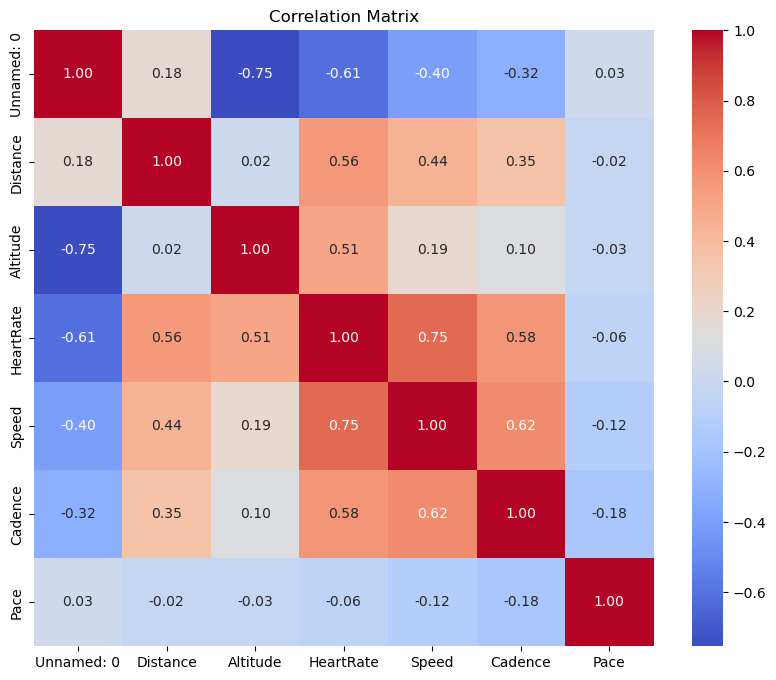

In [67]:
corr_matrix = data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

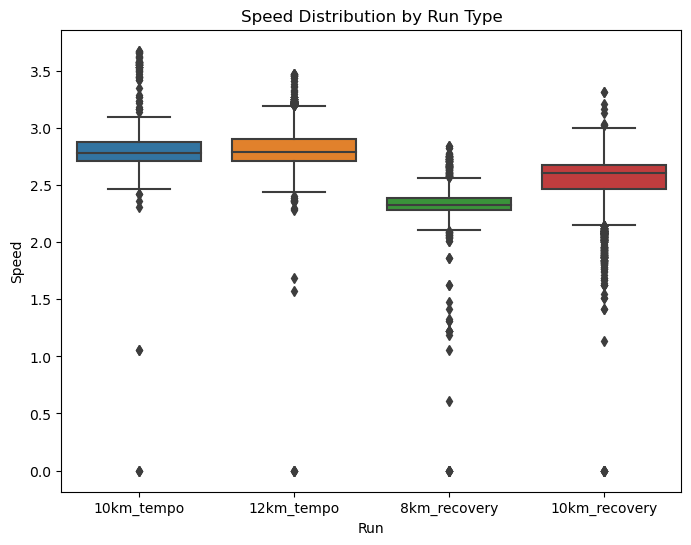

In [68]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Speed', data=data)
plt.title('Speed Distribution by Run Type')
plt.show()

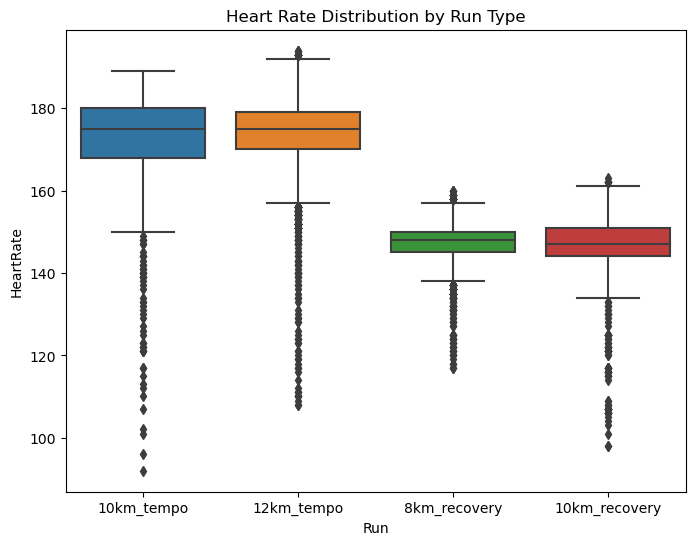

In [69]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='HeartRate', data=data)
plt.title('Heart Rate Distribution by Run Type')
plt.show()

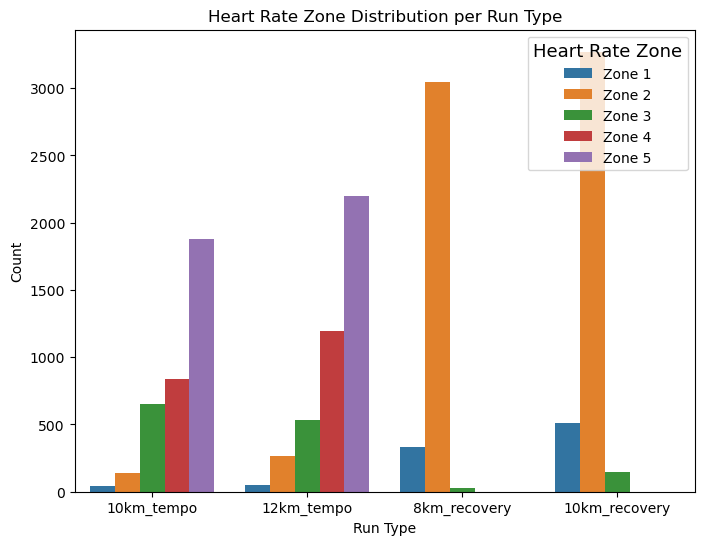

In [70]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Run', hue='HeartRateZone', data=data)
plt.title('Heart Rate Zone Distribution per Run Type')
plt.xlabel('Run Type')
plt.ylabel('Count')
plt.legend(title='Heart Rate Zone', title_fontsize='13', loc='upper right')
plt.show()

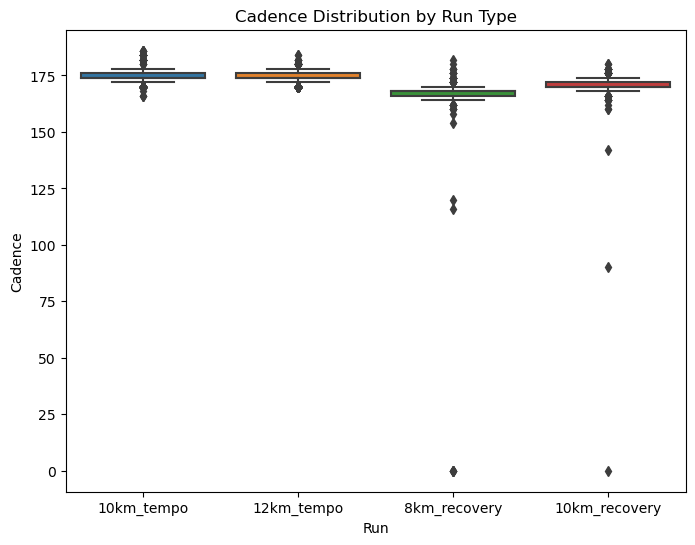

In [71]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Cadence', data=data)
plt.title('Cadence Distribution by Run Type')
plt.show()

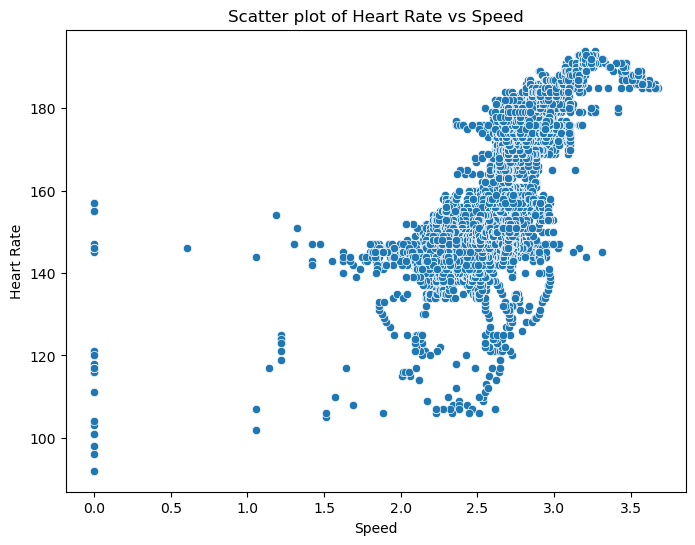

In [72]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Speed', y='HeartRate', data=data)
plt.title('Scatter plot of Heart Rate vs Speed')
plt.xlabel('Speed')
plt.ylabel('Heart Rate')
plt.show()

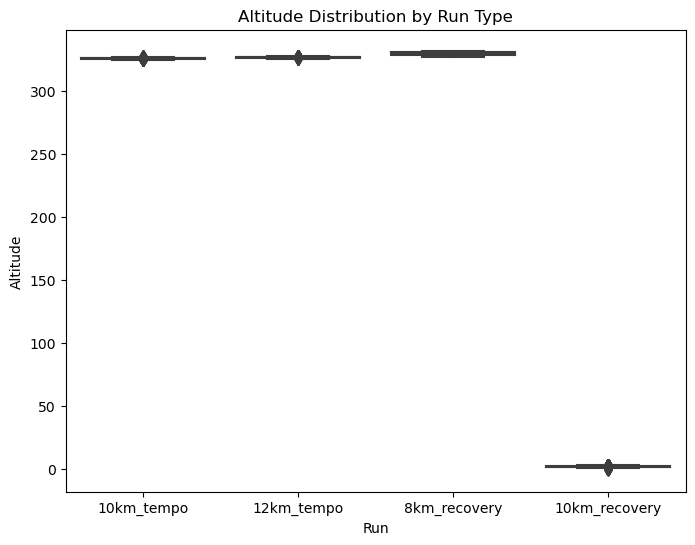

In [74]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Altitude', data=data)
plt.title('Altitude Distribution by Run Type')
plt.show()